In [24]:
from pyspark.sql import functions as f
from pyspark.sql.session import SparkSession

# Machine learning import
from pyspark.ml.classification import (
    LogisticRegression,
    LinearSVC,
    DecisionTreeClassifier
)

from pyspark.ml.feature    import (
    StandardScaler, 
    OneHotEncoder , 
    VectorAssembler
)

In [34]:
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

## Importando CSV

In [26]:
spark = SparkSession\
            .builder.appName('Water-potability')\
                .getOrCreate()

Params: nele terá os parametros para a leitura do conj. de dados no spark

In [29]:
params = dict(
    delimiter = ',',
    header    = 'True',
    inferschema = 'True'
)

Lendo csv

In [30]:
dataset = spark.read\
            .format('csv')\
            .options(**params)\
            .load('dataset/Water/water_potability.csv')

Verificando se inferschema deu certo
> Inferschema: infere o tipo de schema(coluna) do dataframe

In [5]:
dataset.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



> Todos os atributos são numericos

In [6]:
dataset.show(3)

+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|     Conductivity|    Organic_carbon|  Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+----------+
|             NULL| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336|564.3086541722439|  10.3797830780847| 86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862|              NULL|592.8853591348523|15.180013116357259|56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089|              NULL|418.60

verificando a quantidade de valores nulos no conj. de dados

In [17]:
dataset.select(
    [
        f.sum(f.when(f.isnull(column), 1).otherwise(0)).alias(column) \
        for column in dataset.columns
    ]
).toPandas()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,491,0,0,0,781,0,0,162,0,0


Quantidade de instancias do dataset

In [33]:
print("Quantidade de instancia :",dataset.count())

Quantidade de instancia : 3276


Pairplot dos dados

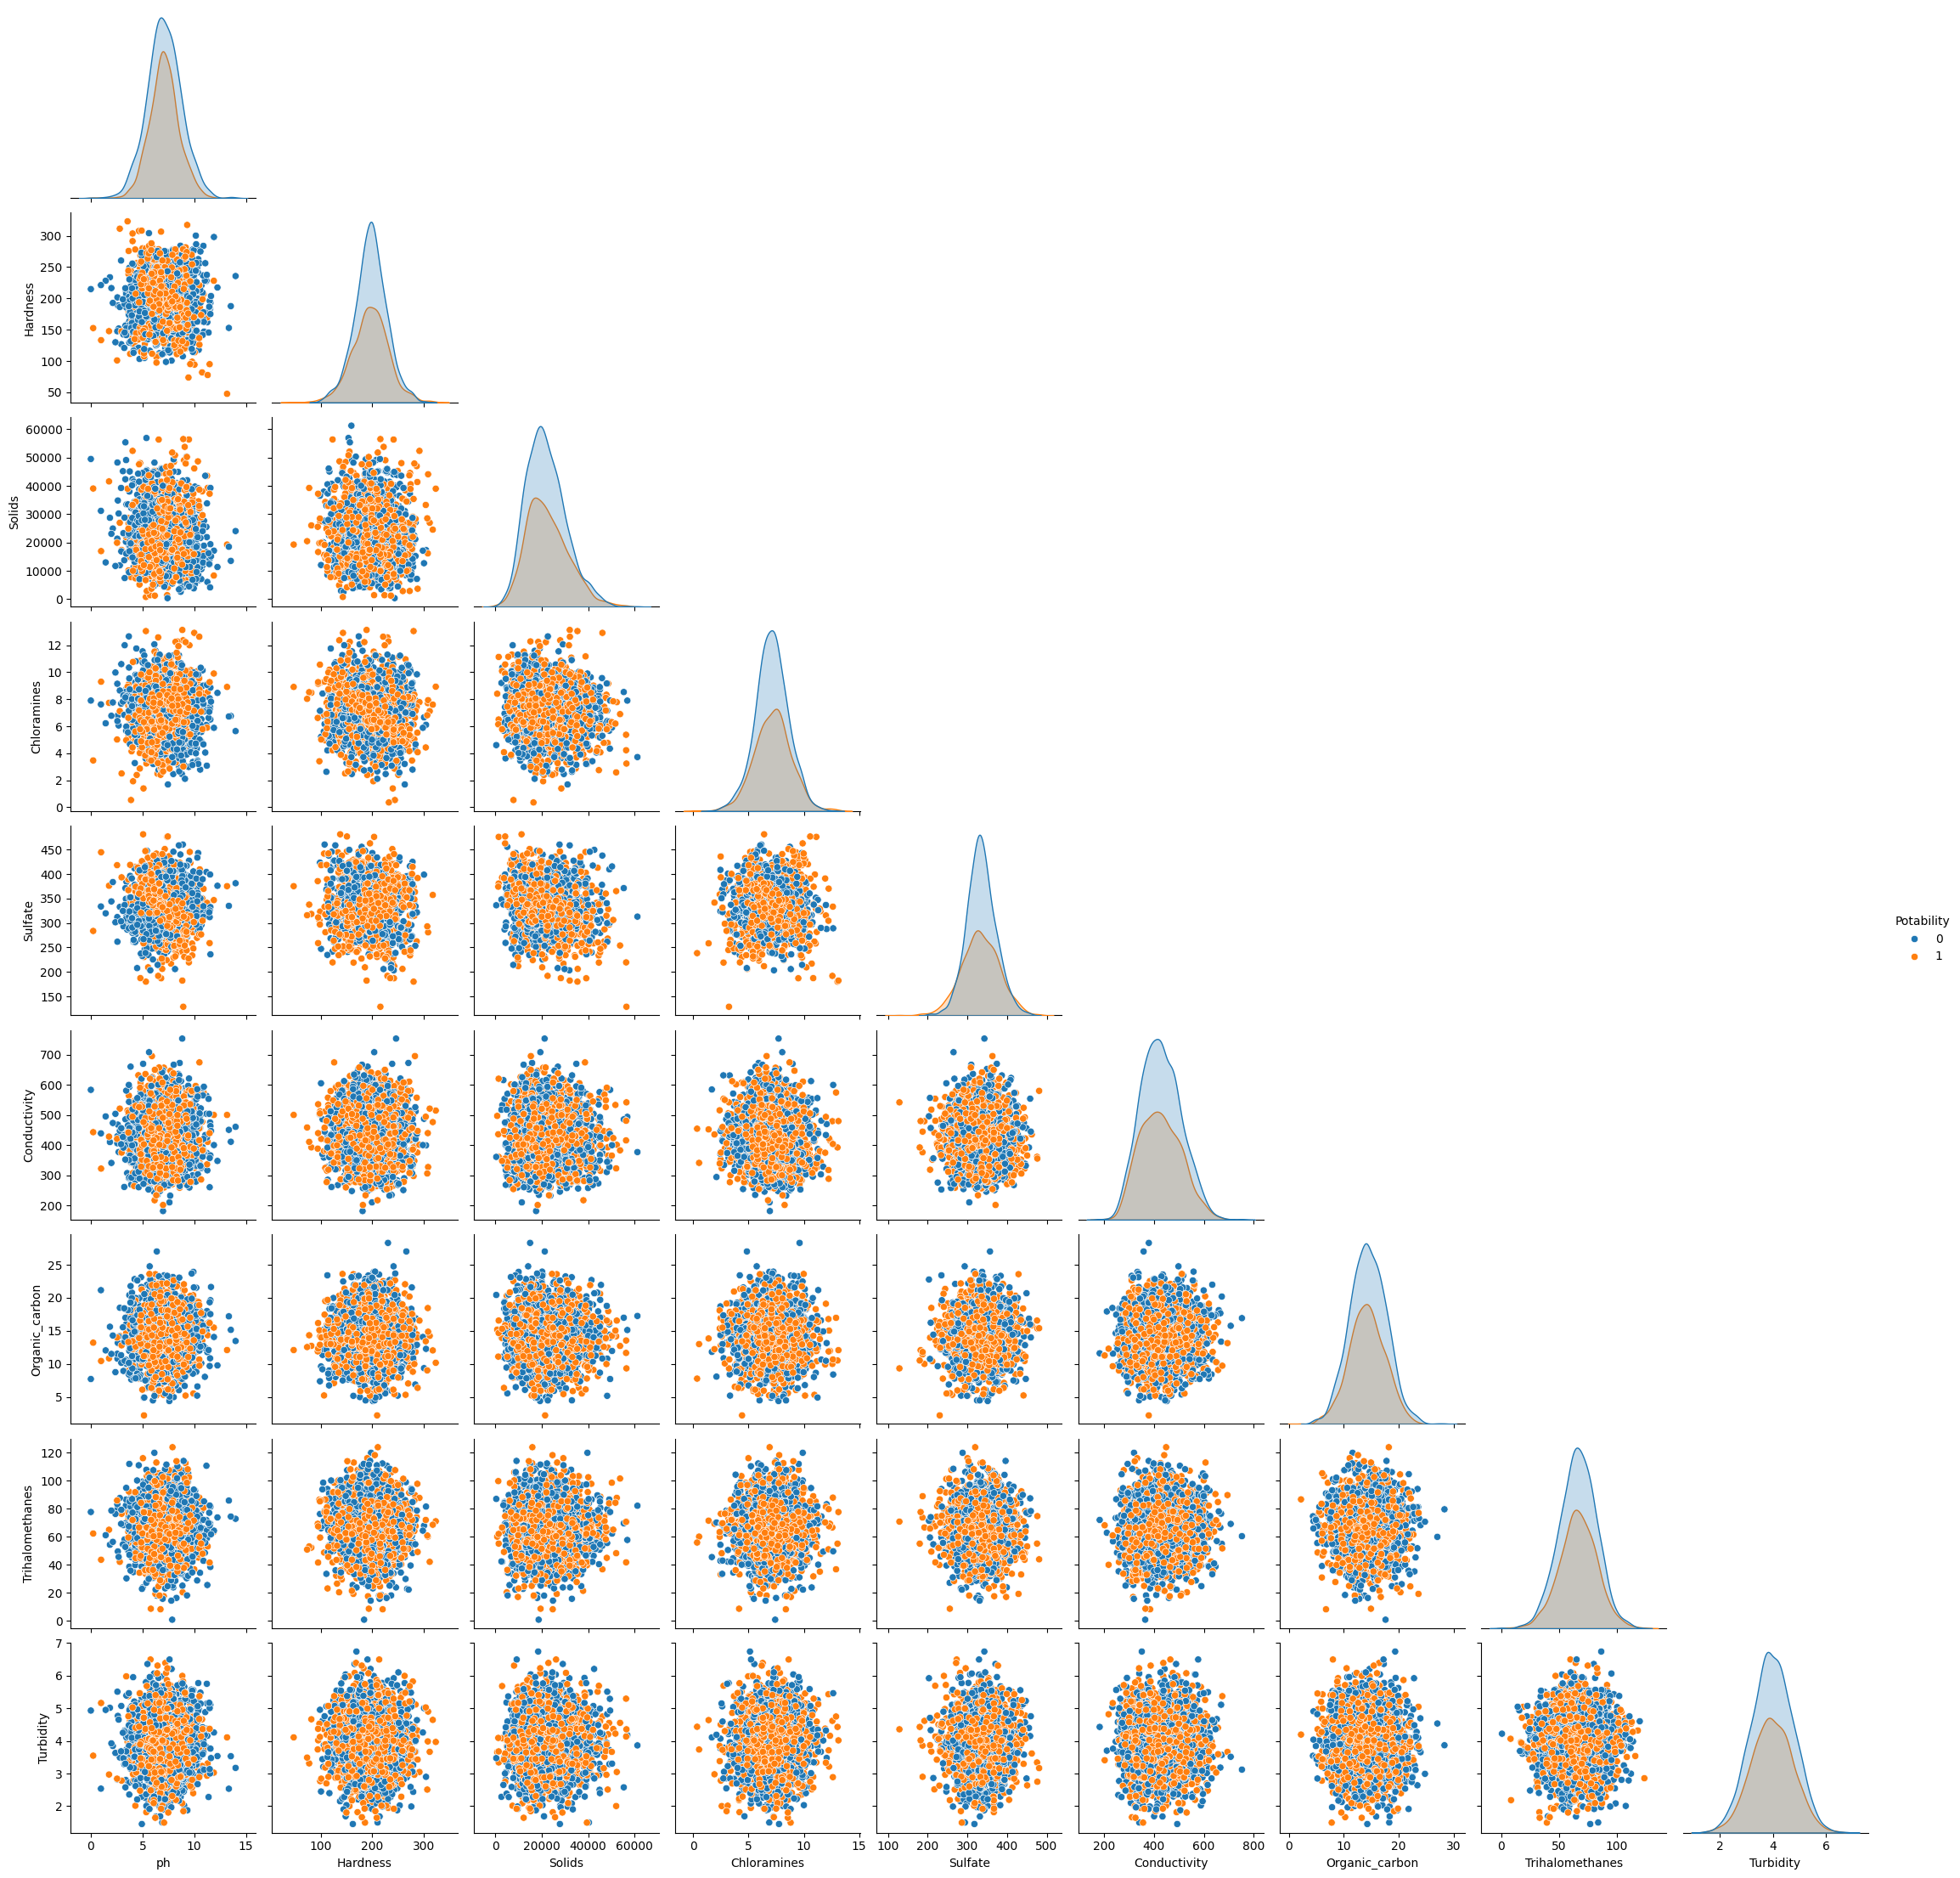

In [36]:
sea.pairplot(data=dataset.toPandas(), hue='Potability', corner=True)

correlação

In [37]:
from scipy.stats import pointbiserialr

In [75]:
subset = dataset.dropna()

In [89]:
target = subset.select('Potability').toPandas()\
                .values.reshape(1, -1)[0]

print('Correlação')
for column_i in dataset.columns[:-1]:
    feature_i = subset.select(column_i).toPandas()\
                       .values.reshape(1, -1)[0]
    valor, _ = pointbiserialr(x=target, y=feature_i)
    print('_'*60)
    print(f'   Potability - {column_i} : {valor:.5f}')
    print(f' P-valor :{_:.5f} {'' _}')

Correlação
____________________________________________________________
   Potability - ph : 0.01453
 P-valor :0.51491
____________________________________________________________
   Potability - Hardness : -0.00151
 P-valor :0.94622
____________________________________________________________
   Potability - Solids : 0.04067
 P-valor :0.06821
____________________________________________________________
   Potability - Chloramines : 0.02078
 P-valor :0.35157
____________________________________________________________
   Potability - Sulfate : -0.01530
 P-valor :0.49279
____________________________________________________________
   Potability - Conductivity : -0.01550
 P-valor :0.48737
____________________________________________________________
   Potability - Organic_carbon : -0.01557
 P-valor :0.48537
____________________________________________________________
   Potability - Trihalomethanes : 0.00924
 P-valor :0.67866
____________________________________________________________
 

Removendo valores nulos

In [90]:
dataset = dataset.dropna()

### Pré-processamento

In [ ]:
padronizacao = StandardScaler()